In [262]:
import networkx as nx
import torch
from torch_geometric.data import Data
import torch_geometric
import numpy as np
from torch_geometric.datasets import CoraFull, CitationFull
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd

from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.transforms import ToUndirected
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric.transforms import ToUndirected
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import TGCN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal


%config InlineBackend.figure_format = 'retina'


In [263]:
ADJ_PATH = '/home/udit/Documents/Progyan/results_new_95/Year_{}.npy'
COORD_PATH = '/home/udit/Documents/Progyan/Lat_lon/lat_lon-{}.csv'

In [293]:
graph_list = []

for year in tqdm(range(2003, 2018)):
    if year == 2005 or year == 2012:
        continue
    i = year
    adj_matrix = np.load(ADJ_PATH.format(i))
    lat_lon_df = pd.read_csv(COORD_PATH.format(i))

    adj_matrix = adj_matrix + adj_matrix.transpose()

    ##### REMOVE ######
    adj_matrix = adj_matrix[:4523, :4523]
    ###################

    adj_matrix[adj_matrix < 0.8] = 0
    np.fill_diagonal(adj_matrix, 0)
    G = nx.from_numpy_matrix(adj_matrix)

    lat_lon_dict = {}
    for i in range(len(lat_lon_df)):
        lat_lon_dict[i] = [lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat'], lat_lon_df.loc[i, 'rain']]

    nx.set_node_attributes(G, lat_lon_dict, 'pos')
    pos = nx.get_node_attributes(G, 'pos')

    central_nodes = []

    for n in G.nodes:
        if G.nodes[n]['pos'][0] > 74.5 and G.nodes[n]['pos'][0] < 86.5 and G.nodes[n]['pos'][1] > 16.5 and G.nodes[n]['pos'][1] < 26.5:
            central_nodes.append(n)

    G = G.subgraph(central_nodes)

    graph_list.append(G)

100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


0it [00:00, ?it/s]/tmp/ipykernel_31966/1229872386.py:14: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/tmp/ipykernel_31966/1229872386.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

0it [00:00, ?it/s]


ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape (2, 3).

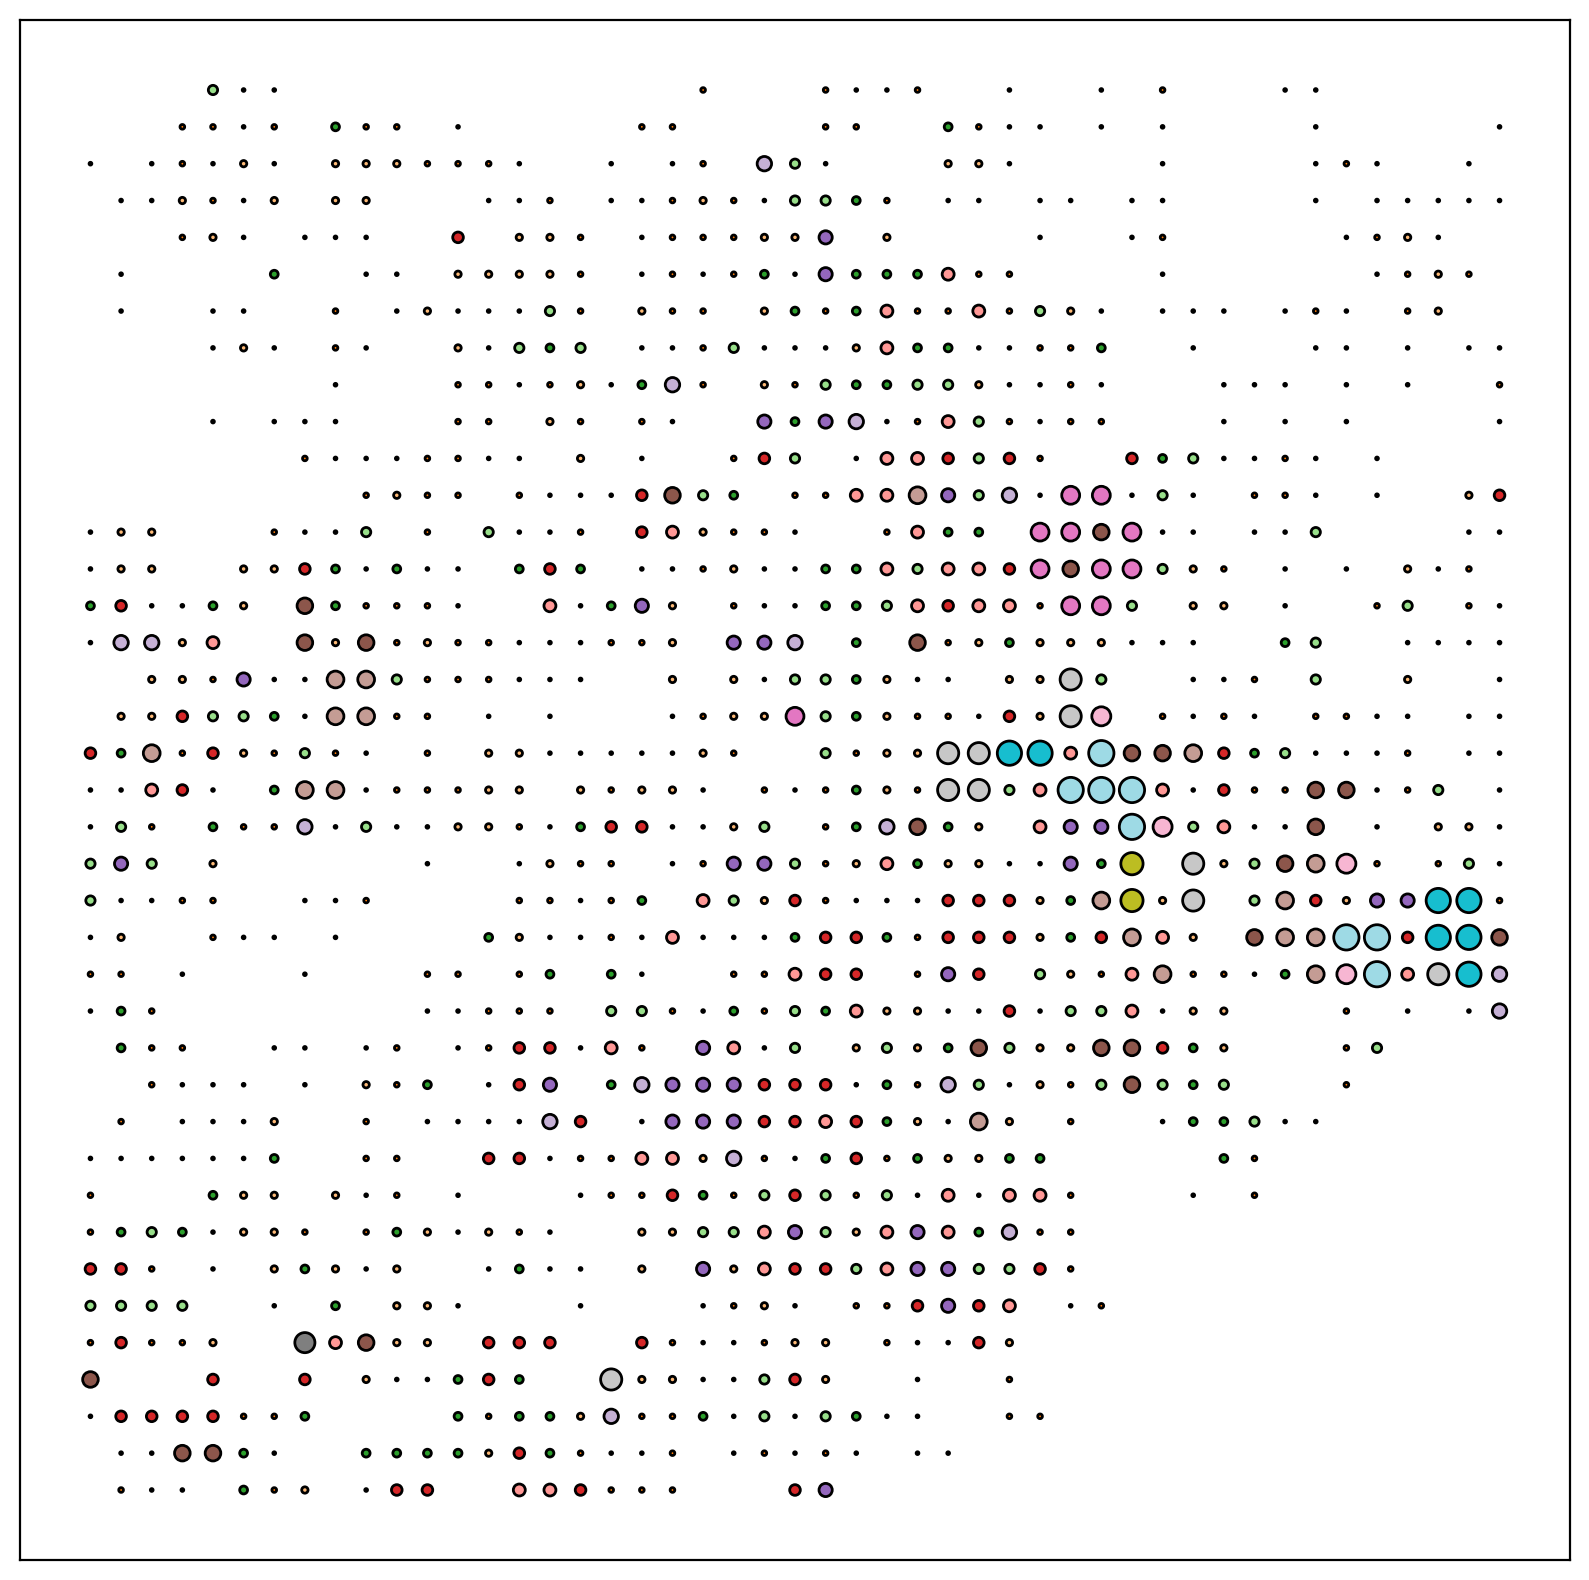

In [294]:
for _, G in tqdm(enumerate(graph_list)):        
    plot = plt.figure(figsize=(10,10))
    india_coords = [[67, 97], [5.5, 38]]
    india_pos = {}

    for node_id, coords in pos.items():
        if coords[1] > 5.5 and coords[1] < 38 and coords[0] > 67 and coords[0] < 97:
            india_pos[node_id] = coords

    d = dict(G.degree)
    degree_dict = dict(G.degree()) 
    degree_values = np.array(list(degree_dict.values())) 

    cmap = plt.cm.get_cmap('tab20')
    cmap_edge = plt.cm.get_cmap('tab20')

    normalized_degrees = (degree_values - degree_values.min()) / (degree_values.max() - degree_values.min())

    node_colors = cmap(normalized_degrees)

    edge_widths = [d['weight'] for (u, v, d) in G.edges(data=True)]
    edge_colors = [d['weight']**3 for (u, v, d) in G.edges(data=True)]

    edge_colors = cmap_edge(edge_colors)

    ################ PLOT NETWORK #####################
    nx.draw_networkx(G, pos = india_pos,
            nodelist=d, 
            width=edge_widths,
            edge_color=edge_colors,
            edgecolors = 'black',
            node_size=[(d[k])**1.5 for k in d],
            with_labels = False,
            node_color=node_colors,)
            
    img = plt.imread('/home/udit/Documents/Progyan/GNN/physical-map-india.jpg')
    plt.imshow(img, extent=[68, 96.5, 5.5, 36.5], alpha=1)
    #####################################################

    save = plt.savefig(f'./temporal_train_graphs/graph{_}.png')

In [295]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [296]:
device = "cuda:0"

In [297]:
lat_lon_df

,lat,lon,rain
0,8.25,77.00,40.610195
1,8.25,77.25,32.462126
2,8.25,77.50,49.369350
3,8.25,77.75,31.447595
4,8.50,76.75,40.670704
...,...,...,...
4863,37.00,75.50,21.156667
4864,37.25,74.50,15.146296
4865,37.25,74.75,17.287486
4866,37.25,75.00,17.651407


In [298]:
lat_lon_df = lat_lon_df.iloc[central_nodes]

list_node_features = []
list_edge_list = []
list_target_features = []
list_edge_weights = []

list_node_features_cpu = []
list_edge_list_cpu = []
list_target_features_cpu = []
list_edge_weights_cpu = []

j = 0

for i, graph in tqdm(enumerate(graph_list[:-1])):
    
    j = 2003 + i 
    if j == 2005 or j == 2012:
        j += 1

    adj_matrix = nx.to_numpy_matrix(graph)
    lat_lon_df = pd.read_csv(COORD_PATH.format(j))

    node_features = []
    target_features = []
    for i in lat_lon_df.index:
        node_features.append([lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat'], lat_lon_df.loc[i, 'rain']])
        target_features.append([lat_lon_df.loc[i, 'rain']])
    node_features = torch.tensor(node_features, dtype=torch.float)


    edge_list = set()
    edge_weights = []
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if adj_matrix[i, j] > 0:
                append_edge = frozenset({i, j})
                edge_list.add(append_edge)
    edge_list = [tuple(x) for x in list(edge_list)]


    for x,y in edge_list:
        edge_weights.append(adj_matrix[x, y])

    edge_list = np.array(edge_list)
    edge_weights = np.array(edge_weights)
    edge_list = edge_list.transpose()

    central_pos = {}
    for _, i in enumerate(central_nodes):
        central_pos[_] = pos[i]

    transform = ToUndirected()

    list_node_features_cpu.append(np.array(node_features))
    list_edge_list_cpu.append(edge_list)
    list_target_features_cpu.append(np.array(node_features[:, 2]))
    list_edge_weights_cpu.append(edge_weights)

    list_node_features.append((node_features).to(device))
    list_edge_list.append((torch.from_numpy(edge_list)).to(device))
    list_target_features.append(node_features[:, 2].to(device))
    list_edge_weights.append(torch.tensor(edge_weights).to(device))

node_features_batch = (list_node_features)
edge_list_batch = (list_edge_list)
target_features_batch = (list_target_features)
edge_weights_batch = (list_edge_weights)

node_features_batch_cpu = list_node_features_cpu
edge_list_batch_cpu = list_edge_list_cpu
target_features_batch_cpu = list_target_features_cpu
edge_weights_batch_cpu = list_edge_weights_cpu



12it [00:35,  2.92s/it]


In [299]:
# np.roll(target_features_batch_cpu, 1)
target_features_batch_cpu = np.roll(target_features_batch_cpu, -1, axis = 0)
target_features_batch = target_features_batch[1:].append(target_features_batch[0])

In [300]:
target_features_batch = torch.from_numpy(target_features_batch_cpu)

In [301]:
dataset = DynamicGraphTemporalSignal(edge_indices= edge_list_batch, edge_weights=edge_weights_batch, features=node_features_batch, targets=target_features_batch)

dataset_cpu = DynamicGraphTemporalSignal(edge_indices= edge_list_batch_cpu, edge_weights=edge_weights_batch_cpu, features=node_features_batch_cpu, targets=target_features_batch_cpu)

In [302]:
edge_list_batch_cpu[0].shape

(2, 2238)

In [303]:
# class RecurrentGCN(torch.nn.Module):
#     def __init__(self, node_features):
#         super(RecurrentGCN, self).__init__()
#         self.recurrent = DCRNN(node_features, 32, 1)
#         self.linear = torch.nn.Linear(32, 1)

#     def forward(self, x, edge_index, edge_weight):
#         h = self.recurrent(x, edge_index, edge_weight)
#         h = F.relu(h)
#         h = self.linear(h)
#         return h

In [304]:
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_count, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNH(node_count, dim_in)
        self.recurrent2 = EvolveGCNH(node_count, dim_in)
        # self.bn1 = torch.nn.BatchNorm1d(dim_in)
        # self.bn2 = torch.nn.BatchNorm1d(dim_in)
        self.dropout = torch.nn.Dropout(0.4).to(device)

        self.linear = torch.nn.Linear(dim_in, 2)
        self.linear_2 = torch.nn.Linear(2, 1)
    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        # h = self.bn(h)
        h = self.recurrent2(h, edge_index, edge_weight).relu()
        h = self.dropout(h)
        # h = self.recurrent2(h, edge_index, edge_weight).relu()
        h = self.linear(h)
        h = self.linear_2(h)
        return h

In [332]:
from torch_geometric.nn.conv import GATv2Conv

class Roland(torch.nn.Module):
    def __init__(self, num_layers, hidden, num_nodes) -> None:
        super().__init__()
        self.num_layers = num_layers
        self.hidden = hidden
        self.num_nodes = num_nodes
        self.conv = torch.nn.ModuleList()
        self.gru = torch.nn.ModuleList()
        self.h_0 = torch.nn.ParameterList()
        self.dropout = torch.nn.Dropout(0.4).to(device)


        self.conv.append(torch.nn.Sequential(
            GATv2Conv(-1, hidden), torch.nn.ReLU()))
        
        for i in range(num_layers - 1):
            self.conv.append(torch.nn.Sequential(
                GATv2Conv(hidden, hidden), torch.nn.ReLU()))
            self.gru.append(torch.nn.GRU(hidden, hidden))
            self.h_0.append(torch.nn.Parameter(torch.randn(1, hidden)))

        self.lin = torch.nn.Linear(hidden, hidden)
        self.lin_mid = torch.nn.Linear(hidden, hidden)
        self.lin2 = torch.nn.Linear(hidden, 1)


    def reset_parameters(self):

        for i in range(self.num_layers):
            self.conv[i].reset_parameters()
            if i != 0:
                self.gru[i-1].reset_parameters()
                self.h_0[i-1].reset_parameters()

        self.lin.reset_parameters()
        self.lin_mid.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x,edge_index):

        for i in range(self.num_layers):
            x = self.conv[i][0](x, edge_index)
            x = self.conv[i][1](x)

            if i != 0:
                x, self.h_0[i-1] = self.gru[i-1](x, self.h_0[i-1])
            
        x = self.lin(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

In [333]:
# model = TemporalGNN(dataset_cpu[0].x.shape[0], dataset_cpu[0].x.shape[1])
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# model.train()
model = Roland(num_layers = 3, hidden = 32, num_nodes = dataset_cpu[0].x.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

Roland(
  (conv): ModuleList(
    (0): Sequential(
      (0): GATv2Conv(-1, 32, heads=1)
      (1): ReLU()
    )
    (1-2): 2 x Sequential(
      (0): GATv2Conv(32, 32, heads=1)
      (1): ReLU()
    )
  )
  (gru): ModuleList(
    (0-1): 2 x GRU(32, 32)
  )
  (h_0): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1x32]
      (1): Parameter containing: [torch.float32 of size 1x32]
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (lin): Linear(in_features=32, out_features=32, bias=True)
  (lin_mid): Linear(in_features=32, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=1, bias=True)
)

In [334]:
# from torch_geometric_temporal.nn.recurrent import MPNNLSTM


# class TemporalGNN(torch.nn.Module):
#     def __init__(self, dim_in, dim_h, num_nodes):
#         super().__init__()
#         self.recurrent = MPNNLSTM(dim_in, dim_h, num_nodes, 1, 0.5).to(device)
#         self.dropout = torch.nn.Dropout(0.2).to(device)
#         self.linear = torch.nn.Linear(2*dim_h + dim_in, 1).to(device)
#         self.linear_2 = torch.nn.Linear(200, 1)
#         self.linear_3 = torch.nn.Linear(100, 50)
#         self.linear_4 = torch.nn.Linear(50, 1) 

#     def forward(self, x, edge_index, edge_weight):
#         h = self.recurrent(x, edge_index, edge_weight).relu()
#         h = self.dropout(h)
#         h = self.linear(h).relu()
#         # # h = self.linear_2(h).relu()
#         # h = self.linear_3(h).relu()
#         # h = self.linear_4(h).relu()
#         return h

# model = TemporalGNN(dataset_cpu[0].x.shape[1], 128, dataset_cpu[0].x.shape[0])
# print(model)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# model.train()


In [335]:
train_dataset, test_dataset = temporal_signal_split(dataset_cpu, train_ratio=0.8)

In [336]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_dataset.targets.reshape(-1, 1))
targets_scaled = []
for _ in train_dataset.targets:
    targets_scaled.append(scaler.transform(_.reshape(-1,1)).reshape(-1,))


In [337]:
train_dataset.targets = np.array(targets_scaled)

In [338]:
test_scaled = []
for _ in test_dataset.targets:
    test_scaled.append(scaler.transform(_.reshape(-1,1)).reshape(-1,))

In [339]:
test_dataset.targets = np.array(test_scaled)

In [340]:
model = model.to("cuda:0")

In [341]:
model.train()

Roland(
  (conv): ModuleList(
    (0): Sequential(
      (0): GATv2Conv(-1, 32, heads=1)
      (1): ReLU()
    )
    (1-2): 2 x Sequential(
      (0): GATv2Conv(32, 32, heads=1)
      (1): ReLU()
    )
  )
  (gru): ModuleList(
    (0-1): 2 x GRU(32, 32)
  )
  (h_0): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1x32 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 1x32 (GPU 0)]
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (lin): Linear(in_features=32, out_features=32, bias=True)
  (lin_mid): Linear(in_features=32, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=1, bias=True)
)

In [342]:
optimizer.lr = 5e-4

In [343]:
import torch.nn as nn
criterion = nn.MSELoss()

In [344]:
print(train_dataset[0].edge_attr)
train_dataset[0].edge_attr.max()
# print(train_dataset[1])

tensor([0.8000, 0.8000, 1.0000,  ..., 0.8940, 0.8000, 1.0000])


tensor(1.)

In [345]:
# model.train()
for epoch in (range(800)):
    model.train()
    loss_x = 0
    # print(epoch, end = "\r")
    for i, snapshot in enumerate(train_dataset):

        # print(snapshot.x.shape, snapshot.edge_index.shape, snapshot.edge_attr.shape, snapshot.y.shape)
        optimizer.zero_grad()
        snapshot = snapshot.cuda()
        y_pred = model(snapshot.x,snapshot.edge_index)
        y_pred = y_pred.squeeze(-1)
        # print(y_pred.shape, snapshot.y.shape)
        # loss = loss + torch.mean(criterion(y_pred, snapshot.y))
        loss = criterion(y_pred, snapshot.y)
        loss_x+=loss.item()
    # loss = loss / (i+1)
        loss.backward()
        optimizer.step()
    if epoch % 20 == 0:
        print(loss_x, "|", epoch)

    model.eval()
    loss = 0
    for i, snapshot in enumerate(test_dataset):
        snapshot = snapshot.to(device)
        y_pred = model(snapshot.x, snapshot.edge_index)
        mse = torch.mean(torch.tensor((scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))-scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1)))**2).sqrt())
        loss += mse
    loss = loss / (i+1)
    if loss<9.6:
        break
    print(f'MSE: {loss.item():.4f}')
    
    # print(loss_x/len(train_dataset), epoch, end = "\r")

0.283360892906785 | 0
MSE: 13.7713
MSE: 15.6970
MSE: 12.3382
MSE: 13.0709
MSE: 11.3322
MSE: 11.7246
MSE: 11.2543
MSE: 11.2509
MSE: 11.2470
MSE: 11.1960
MSE: 11.1549
MSE: 10.9948
MSE: 10.9522
MSE: 10.9047
MSE: 10.8495
MSE: 10.7943
MSE: 10.6909
MSE: 10.5534
MSE: 10.4292
MSE: 10.3862
0.04830586351454258 | 20
MSE: 10.2946
MSE: 10.2963
MSE: 10.1990
MSE: 10.1460
MSE: 10.0597
MSE: 10.0957
MSE: 10.0268
MSE: 10.0872
MSE: 9.9885
MSE: 10.0254
MSE: 9.9065
MSE: 9.9913
MSE: 9.8224
MSE: 9.9773
MSE: 9.8092
MSE: 9.9308
MSE: 9.7545
MSE: 9.8911
MSE: 9.7477
MSE: 9.8444
0.04358604666776955 | 40
MSE: 9.7527
MSE: 9.8062
MSE: 9.7623
MSE: 9.7839
MSE: 9.7615
MSE: 9.7612
MSE: 9.7524
MSE: 9.7316
MSE: 9.7218
MSE: 9.6953
MSE: 9.7063
MSE: 9.7155
MSE: 9.6890
MSE: 9.6836
MSE: 9.6860
MSE: 9.6559
MSE: 9.6730
MSE: 9.6666
MSE: 9.6481
MSE: 9.6641
0.04223950416781008 | 60
MSE: 9.6311
MSE: 9.6641
MSE: 9.6105
MSE: 9.6551
MSE: 9.6158
MSE: 9.6557
MSE: 9.6525
MSE: 9.6330
MSE: 9.6525
MSE: 9.6474
MSE: 9.6604
MSE: 9.6816
MSE: 9.634

In [ ]:
!pip install plotly

In [153]:
(torch.tensor(scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1))).t() - snapshot.x.t()[2].detach().cpu())

tensor([[ 6.9905,  8.2676, 48.3292,  ...,  2.3415,  4.0407,  5.3900]],
       dtype=torch.float64)

In [346]:
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    print(i)
    snapshot = snapshot.to(device)
    y_pred = model(snapshot.x, snapshot.edge_index)
    mse = torch.mean(torch.tensor((scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))-scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1)))**2).sqrt())
    loss += mse
    break
loss = loss / (i+1)
print(f'MSE: {loss.item():.4f}')

0
MSE: 6.3009


In [325]:
i

0

In [326]:
!pip install nbformat
import nbformat

In [327]:
!pip install -U kaleido

In [328]:
np.save('a.npy',(snapshot.y.detach().cpu().reshape(-1,1)))
np.save('b.npy', (y_pred.detach().cpu().reshape(-1,1)) + 0.1)

In [329]:
y1.shape

torch.Size([4868])

In [330]:
y1

tensor([0.1289, 0.1614, 0.0888,  ..., 0.0673, 0.0768, 0.0856])

In [347]:
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import init_notebook_mode, iplot

# Create two numpy arrays with some sample data
x = np.linspace(0, 5000, 4868)
y1 = (snapshot.y.detach().cpu().reshape(-1,))
y2 = (y_pred.detach().cpu().reshape(-1,))

# Create the traces for each line
trace1 = go.Scatter(x=x, y=y1, mode='lines', name='Sine')
trace2 = go.Scatter(x=x, y=y2, mode='lines', name='Cosine')

# Create the layout for the plot
layout = go.Layout(title='Sine and Cosine Plot')

# Create the figure object and add the traces and layout
fig = go.Figure(data=[trace1, trace2], layout=layout)

iplot(fig)

# Show the plot


In [ ]:
y_pred

tensor([[0.1630],
        [0.1699],
        [0.1618],
        ...,
        [0.1648],
        [0.1655],
        [0.1662]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
!pip install seaborn

In [ ]:
import seaborn as sns

In [ ]:
sns.set()

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

tensor([29.4268, 36.5287, 20.6513,  ..., 15.9564, 18.0335, 19.9428],
       device='cuda:0')

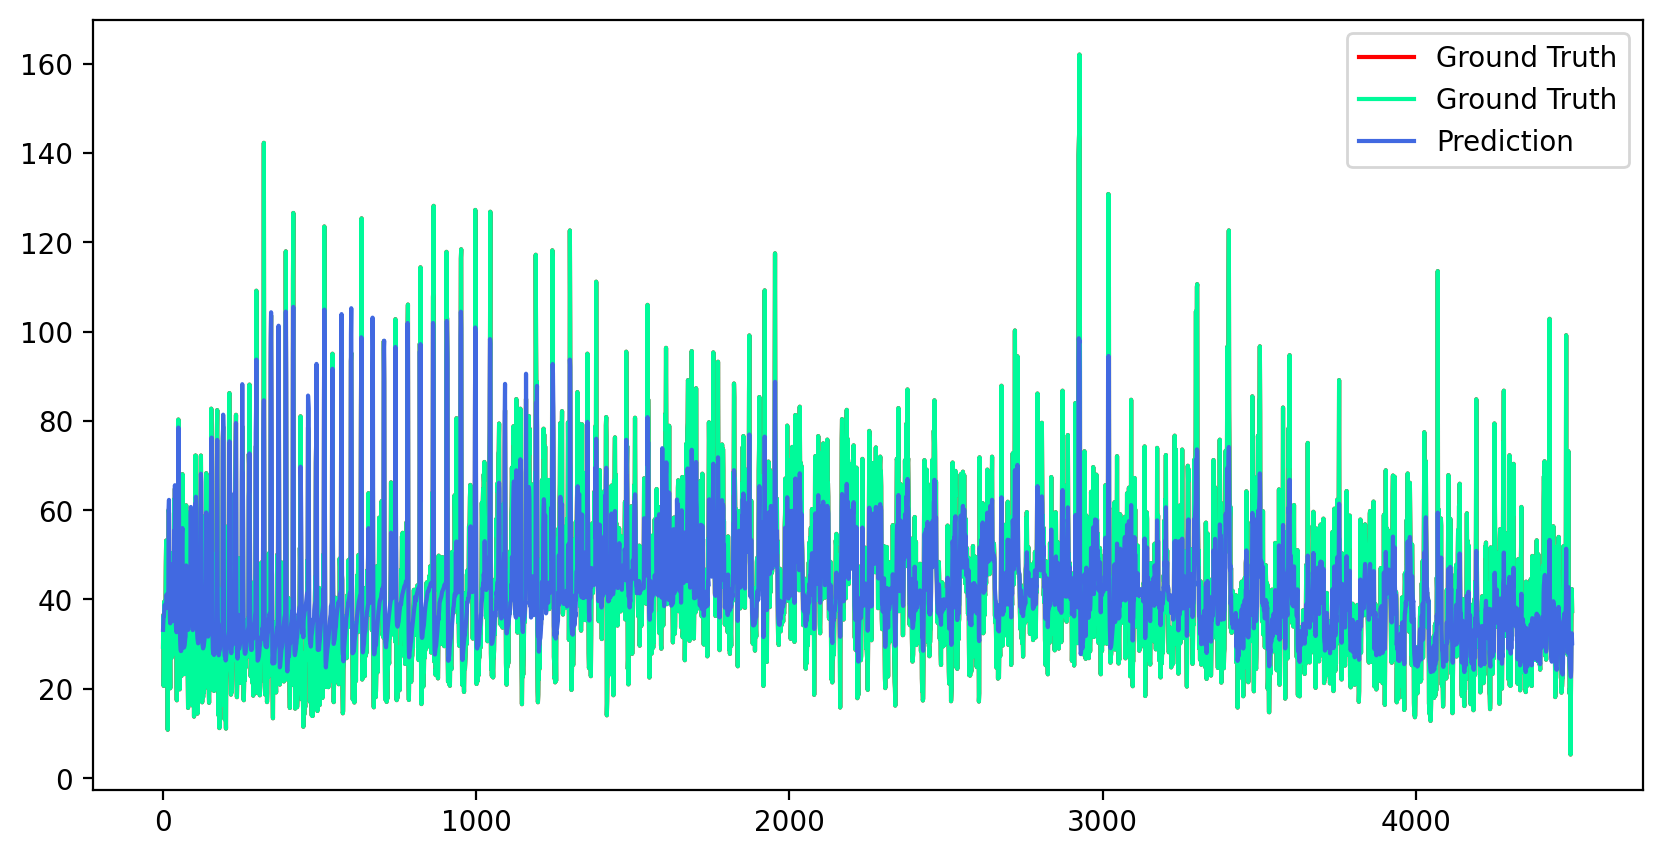

In [292]:
plt.figure(figsize=(10, 5))
plt.plot((snapshot.x.t()[2].detach().cpu().reshape(-1,1))[:4500, :], label = "Ground Truth", color = "red")

plt.plot(scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1))[:4500, :], label = "Ground Truth", color = "mediumspringgreen")
plt.plot(scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1))[:4500, :], label = "Prediction", color = "royalblue")
# plt.plot((snapshot.x.t()[2].detach().cpu().reshape(-1,1))[:4500, :], label = "Ground Truth", color = "red")

plt.legend()

In [242]:
snapshot.x

tensor([[77.0000,  8.2500, 36.4173],
        [77.2500,  8.2500, 44.7962],
        [77.5000,  8.2500, 68.9805],
        ...,
        [74.7500, 37.2500, 18.2979],
        [75.0000, 37.2500, 22.0741],
        [75.2500, 37.2500, 25.3328]], device='cuda:0')

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(scaler.inverse_transform(snapshot.y.detach().cpu().reshape(-1,1)), scaler.inverse_transform(y_pred.detach().cpu().reshape(-1,1)))**0.5

19.25259982166782